In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import os

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dim = int(sqrt(len(df.columns)-1))
print(dim)

28


In [5]:
ix_sample = 8
sample = df.drop(columns='label').iloc[[ix_sample]].values.reshape(dim,dim)

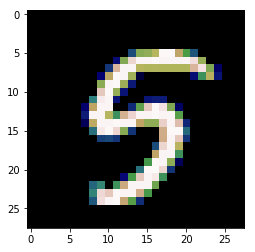

In [6]:
from PIL import Image
from matplotlib import cm
from matplotlib.pyplot import imshow
%matplotlib inline
im = Image.fromarray(np.uint8(cm.gist_earth(sample)*255))
imshow(im)

In [7]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data, dtype=np.int16).reshape(-1)
    return np.eye(nb_classes,dtype=np.int8)[targets]

In [8]:
from sklearn.model_selection import train_test_split
labels = df['label'].values
labels, levels = pd.factorize(labels)
classes = len(np.unique(labels))
y = indices_to_one_hot(labels, classes)
data = df.drop(columns=['label']).values
x_train, x_test, y_train, y_test = train_test_split(data,y, train_size=0.75)

In [9]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
print("classes:", classes)
print(levels)

31500
10500
31500
10500
classes: 10
[1 0 4 7 3 5 8 9 2 6]


In [10]:
print(y_train.shape)

(31500, 10)


In [ ]:
### Simple NN
from keras.layers import Dense, Input
from keras.models import Model

input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(input_shape,))
dense1 = Dense(units=1000, activation='relu')(inputs)
dense2 = Dense(units=1000, activation='sigmoid')(dense1)
dense3 = Dense(units=1000, activation='sigmoid')(dense2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)



In [ ]:
from keras.optimizers import Adam

lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
BATCH_SIZE = 256
path = 'NN'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

In [ ]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [ ]:
## some visual testing

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [19]:
def generate_submission(model, x_test):
    import csv
    csv_file = open(path+'/submission.csv', 'w', newline='', encoding='utf-8')
    writer = csv.writer(csv_file)
    writer.writerow(['ImageId','Label'])
    pred = model.predict(x_test)
    #ix = 155
    #im = Image.fromarray(np.uint8(cm.gist_earth(df.values[ix].reshape(dim,dim))*255))
    #imshow(im)
    #print(levels[np.argmax(pred[ix])])
    for ix, p in enumerate(pred):
        writer.writerow([ix+1, levels[np.argmax(p)]])
    csv_file.close()

In [ ]:
test_df = pd.read_csv('data/test.csv') ### 0.96785
generate_submission(model, test_df.values)

In [12]:
### CNN
from keras.layers import Dense, Input, Conv2D, MaxPooling2D
from keras.layers.core import Reshape, Flatten
from keras.models import Model


filters = 10
kernel_size = 4
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)
conv1 = Conv2D(filters = filters, kernel_size = kernel_size)(reshape)
max1 = MaxPooling2D()(conv1)
flat1=Flatten()(max1)
dense1 = Dense(units=1000, activation='relu')(flat1)
dense2 = Dense(units=1000, activation='sigmoid')(dense1)
dense3 = Dense(units=1000, activation='sigmoid')(dense2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 10)        170       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1441000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
__________

In [14]:
from keras.optimizers import Adam

lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
BATCH_SIZE = 256
path = 'CNN'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

(31500, 784)
Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 5s 155us/step - loss: 0.7810 - acc: 0.8237 - val_loss: 0.3002 - val_acc: 0.9207
Epoch 2/100
31500/31500 [==============================] - 2s 70us/step - loss: 0.2175 - acc: 0.9416 - val_loss: 0.1914 - val_acc: 0.9444
Epoch 3/100
31500/31500 [==============================] - 2s 70us/step - loss: 0.1420 - acc: 0.9622 - val_loss: 0.1521 - val_acc: 0.9550
Epoch 4/100
31500/31500 [==============================] - 2s 69us/step - loss: 0.1018 - acc: 0.9727 - val_loss: 0.1207 - val_acc: 0.9639
Epoch 5/100
31500/31500 [==============================] - 2s 69us/step - loss: 0.0745 - acc: 0.9808 - val_loss: 0.1072 - val_acc: 0.9695
Epoch 6/100
31500/31500 [==============================] - 2s 70us/step - loss: 0.0535 - acc: 0.9868 - val_loss: 0.0931 - val_acc: 0.9720
Epoch 7/100
31500/31500 [==============================] - 2s 70us/step - loss: 0.0365 - acc: 0.9923 - val_l

In [16]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[1126    0    0    4    1    0    1    1    3    0]
 [   0  956    2    0    0    2    3    1    0    5]
 [   2    0  983    2    0    1    1    5    3    5]
 [   2    1    4 1100    0    0    1    9    8    0]
 [   1    0    0    3 1078   12    9    4    7    0]
 [   1    4    3    1    5  937    1    5    0    6]
 [   4    1    2    1    5    5  965    4    3    5]
 [   2    2    8    5    3    4    6 1076    0    0]
 [   3    5    4    4    3    2    1    1 1032    1]
 [   2    4    2    0    0    1    2    0    1 1022]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1136
           1       0.98      0.99      0.98       969
           2       0.98      0.98      0.98      1002
           3       0.98      0.98      0.98      1125
           4       0.98      0.97      0.98      1114
           5       0.97      0.97      0.97       963
           6       0.97      0.97      0.97       995
           7       0.97      0.97   

In [21]:
test_df = pd.read_csv('data/test.csv').values ### 0.97671
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)

In [27]:
### CNN + dropout
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers.core import Reshape, Flatten
from keras.models import Model


filters = 10
kernel_size = 4
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)
conv1 = Conv2D(filters = filters, kernel_size = kernel_size)(reshape)
max1 = MaxPooling2D()(conv1)
flat1=Flatten()(max1)
dense1 = Dense(units=1000, activation='relu')(flat1)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(units=1000, activation='sigmoid')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(units=1000, activation='sigmoid')(drop2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

In [28]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 10)        170       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              1441000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
__________

In [29]:
from keras.optimizers import Adam

lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
BATCH_SIZE = 256
path = 'CNN+d'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

(31500, 28, 28)
Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 3s 97us/step - loss: 1.4208 - acc: 0.6160 - val_loss: 0.5046 - val_acc: 0.8515
Epoch 2/100
31500/31500 [==============================] - 2s 72us/step - loss: 0.5091 - acc: 0.8685 - val_loss: 0.3001 - val_acc: 0.9090
Epoch 3/100
31500/31500 [==============================] - 2s 72us/step - loss: 0.3304 - acc: 0.9066 - val_loss: 0.2407 - val_acc: 0.9289
Epoch 4/100
31500/31500 [==============================] - 2s 73us/step - loss: 0.2622 - acc: 0.9224 - val_loss: 0.2060 - val_acc: 0.9393
Epoch 5/100
31500/31500 [==============================] - 2s 73us/step - loss: 0.2198 - acc: 0.9343 - val_loss: 0.1843 - val_acc: 0.9446
Epoch 6/100
31500/31500 [==============================] - 2s 73us/step - loss: 0.1869 - acc: 0.9443 - val_loss: 0.1629 - val_acc: 0.9524
Epoch 7/100
31500/31500 [==============================] - 2s 73us/step - loss: 0.1645 - acc: 0.9504 - val

Epoch 28/100
31500/31500 [==============================] - 2s 73us/step - loss: 0.0311 - acc: 0.9901 - val_loss: 0.0934 - val_acc: 0.9784
Epoch 29/100
31500/31500 [==============================] - 2s 72us/step - loss: 0.0302 - acc: 0.9908 - val_loss: 0.0918 - val_acc: 0.9779
Epoch 30/100
31500/31500 [==============================] - 2s 72us/step - loss: 0.0327 - acc: 0.9893 - val_loss: 0.0925 - val_acc: 0.9777
Epoch 31/100
31500/31500 [==============================] - 2s 73us/step - loss: 0.0284 - acc: 0.9908 - val_loss: 0.0872 - val_acc: 0.9789
Epoch 32/100
31500/31500 [==============================] - 2s 72us/step - loss: 0.0231 - acc: 0.9925 - val_loss: 0.0902 - val_acc: 0.9787
Epoch 33/100
31500/31500 [==============================] - 2s 73us/step - loss: 0.0228 - acc: 0.9929 - val_loss: 0.0888 - val_acc: 0.9794
Epoch 34/100
31500/31500 [==============================] - 2s 74us/step - loss: 0.0219 - acc: 0.9933 - val_loss: 0.0930 - val_acc: 0.9788
Epoch 35/100
31488/31500 [=

In [31]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[1124    0    0    2    3    0    0    0    7    0]
 [   0  956    1    1    1    3    1    2    0    4]
 [   2    0  986    1    0    1    1    4    1    6]
 [   2    1    4 1103    1    2    1    3    8    0]
 [   0    0    0    5 1088    8    2    3    8    0]
 [   0    4    2    0    8  938    3    4    0    4]
 [   4    2    3    0    6    4  961    6    5    4]
 [   2    2   11    6    5    5    6 1069    0    0]
 [   0    2    3    5    5    1    2    1 1037    0]
 [   1    4    1    0    0    0    0    0    0 1028]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1136
           1       0.98      0.99      0.99       969
           2       0.98      0.98      0.98      1002
           3       0.98      0.98      0.98      1125
           4       0.97      0.98      0.98      1114
           5       0.98      0.97      0.97       963
           6       0.98      0.97      0.97       995
           7       0.98      0.97   

In [33]:
test_df = pd.read_csv('data/test.csv').values ### 0.98085
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)

In [53]:
### CNN bigger + dropout
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers.core import Reshape, Flatten
from keras.models import Model


filters = 100
kernel_size = 4
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)
conv1 = Conv2D(filters = filters, kernel_size = kernel_size)(reshape)
max1 = MaxPooling2D()(conv1)
conv2 = Conv2D(filters = filters, kernel_size = kernel_size)(max1)
max2 = MaxPooling2D()(conv2)
flat1=Flatten()(max2)
dense1 = Dense(units=200, activation='relu')(flat1)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(units=400, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(units=200, activation='sigmoid')(drop2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

In [54]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 100)       1700      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 100)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 100)         160100    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 100)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
__________

In [55]:
from keras.optimizers import Adam

lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 100
BATCH_SIZE = 256
path = 'bCNN+d'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

(31500, 28, 28)
Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 5s 152us/step - loss: 1.8628 - acc: 0.3904 - val_loss: 0.7019 - val_acc: 0.8210
Epoch 2/100
31500/31500 [==============================] - 4s 122us/step - loss: 0.9472 - acc: 0.7617 - val_loss: 0.3431 - val_acc: 0.9011
Epoch 3/100
31500/31500 [==============================] - 4s 122us/step - loss: 0.5626 - acc: 0.8653 - val_loss: 0.2461 - val_acc: 0.9302
Epoch 4/100
31500/31500 [==============================] - 4s 122us/step - loss: 0.3832 - acc: 0.9084 - val_loss: 0.1985 - val_acc: 0.9455
Epoch 5/100
31500/31500 [==============================] - 4s 124us/step - loss: 0.2849 - acc: 0.9312 - val_loss: 0.1728 - val_acc: 0.9528
Epoch 6/100
31500/31500 [==============================] - 4s 122us/step - loss: 0.2339 - acc: 0.9421 - val_loss: 0.1482 - val_acc: 0.9618
Epoch 7/100
31500/31500 [==============================] - 4s 125us/step - loss: 0.1933 - acc: 0.951

31500/31500 [==============================] - 4s 121us/step - loss: 0.0459 - acc: 0.9872 - val_loss: 0.0759 - val_acc: 0.9849
Epoch 29/100
31500/31500 [==============================] - 4s 121us/step - loss: 0.0432 - acc: 0.9880 - val_loss: 0.0872 - val_acc: 0.9826
Epoch 30/100
31500/31500 [==============================] - 4s 121us/step - loss: 0.0412 - acc: 0.9879 - val_loss: 0.0762 - val_acc: 0.9838
Epoch 31/100
31488/31500 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9890Epoch 00031: val_acc did not improve

Epoch 00031: reducing learning rate to 3.2999999166349884e-05.
31500/31500 [==============================] - 4s 124us/step - loss: 0.0372 - acc: 0.9890 - val_loss: 0.0784 - val_acc: 0.9846
Epoch 32/100
31500/31500 [==============================] - 4s 121us/step - loss: 0.0331 - acc: 0.9912 - val_loss: 0.0733 - val_acc: 0.9859
Epoch 33/100
31500/31500 [==============================] - 4s 121us/step - loss: 0.0303 - acc: 0.9915 - val_loss: 0.0752 - val_a

In [57]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[1126    1    0    5    1    1    0    0    1    1]
 [   0  961    1    0    0    0    1    3    1    2]
 [   1    0  990    2    0    0    1    3    0    5]
 [   1    0    2 1110    1    0    2    2    7    0]
 [   1    0    0    3 1095    5    0    2    8    0]
 [   0    2    0    1    4  946    4    2    0    4]
 [   1    1    3    0    2    0  979    5    4    0]
 [   1    1    3    2    2    2    3 1092    0    0]
 [   2    1    2    4    3    0    0    1 1042    1]
 [   1    7    0    0    0    0    3    0    0 1023]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1136
           1       0.99      0.99      0.99       969
           2       0.99      0.99      0.99      1002
           3       0.98      0.99      0.99      1125
           4       0.99      0.98      0.99      1114
           5       0.99      0.98      0.99       963
           6       0.99      0.98      0.98       995
           7       0.98      0.99   

In [59]:
test_df = pd.read_csv('data/test.csv').values ### 0.98757
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)